## Loading Dataset and Importing Libraries:

Let's start off with few essential __Imports__. Below I've explained briefly the purpose of imported libraries.

__pandas:__ creating dataframes and data pre-processing.  
__matplotlib:__ data visualization.  
__seaborn:__ data visualization.  
__warnings:__ to get rid off those annoying warnigns.    
__gensim:__ creating word embeddings, implementing __Word2Vec__ for keyword column.  
__keras:__ for implementing deep neural networks and Keras Functional API (for multiple input models).    
__nltk:__ for performing Natural language preprocessing tasks (stop words removal, tokenization etc).    
__sklearn:__ splitting the training and test data, features normalizations, shuffling dataframe and for applying ML algorithms if needed!    
__collections:__ since it gets tidious sometimes to write your own code, for word count, BOW, etc. So it's better to use, built-in pythons's collections library.  

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gensim
import keras
from keras.layers import Input, Dense, concatenate, Activation
from keras.models import Sequential
from keras.models import Model
import nltk
from nltk import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle # we can also shuffle in input_func with tensorflow
warnings.filterwarnings("ignore")
from collections import Counter

%matplotlib inline

__Okay.__ Once we're done with importing all the libraries we needed. Let's go ahead and load our data set. Check the head of it, get some basic information about every single feature, and finally applying pandas built-in describe() method, to see some high-level statistical insighs of the data set have.

In [34]:
df = pd.read_csv('SEM_KeyWord_Dataset.csv')

In [35]:
df.head()

,Date,Market,Keyword,Average.Position,CPC,Clicks,CTR,Impressions,Cost
0,20120524,US-Market,secure online back up,0.0,0.0,0.00,0.00%,0.0,0.00
1,20120524,US-Market,agile management software,1.0,1.2,21.22,8.20%,260.0,25.45
2,20120524,US-Market,crm for financial,0.0,0.0,0.00,0.00%,0.0,0.00
3,20120524,US-Market,disaster recovery planning for it,0.0,0.0,0.00,0.00%,0.0,0.00
4,20120524,US-Market,tracking a vehicle,0.0,0.0,0.00,0.00%,0.0,0.00


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356054 entries, 0 to 356053
Data columns (total 9 columns):
Date                356054 non-null int64
Market              356054 non-null object
Keyword             355575 non-null object
Average.Position    353018 non-null float64
CPC                 353018 non-null float64
Clicks              353018 non-null float64
CTR                 353018 non-null object
Impressions         353018 non-null float64
Cost                353018 non-null float64
dtypes: float64(5), int64(1), object(3)
memory usage: 24.4+ MB


In [37]:
df.describe()

,Date,Average.Position,CPC,Clicks,Impressions,Cost
count,3.560540e+05,353018.000000,353018.000000,353018.000000,3.530180e+05,3.530180e+05
mean,2.012269e+07,0.611737,14.285071,439.052699,1.874365e+04,3.598259e+03
std,3.577676e+03,0.643839,37.858433,7559.532663,2.970826e+05,5.718301e+04
min,2.012052e+07,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00
25%,2.012090e+07,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00
50%,2.012102e+07,1.000000,1.100000,2.120000,1.290000e+02,8.070000e+00
75%,2.012122e+07,1.000000,12.100000,35.230000,1.571000e+03,3.749975e+02
max,2.013021e+07,12.000000,632.730000,441963.500000,1.566667e+07,3.269108e+06


So! After getting a bird-eye view, of our dataset, we can see that we need to pre-process our dataset, in order to apply any __Machine__ or __Deep__ learning algorithms.

First thing, I'm gonna do, is to remove that "%" from our __CTR__ columns, and re-convert those values to floating point numbers. I could not have done that, but since I'm intending to use this feature in our dataset, I must dot that. And I'll explain later why, I want to use that feature in our Training model.

Then, I'll drop all then __NaN__ values in our data set. And make sure, we're I'm not left with any __NaN__ value in my dataset, as it cas seriously reduce the performance of the model.

Then, I'll move on to pre-process the __Market__ feature. This is very imported, since my task requires, to must have this column, so I'll have to find out the way to incorporte this. This is very simple, I'll go ahead an map those values with a dictionary that returns for ___1___ for __US-Market__ and __-1__ for __UK-Market__. 
The reason I've chosen those values, is when I give this feature as an __input__ to my deep learnig model, this will get multiplied with __weights__. And if we have value mapped as __Zero__ it will make the product equals to __Zeros__, and hence will eventually reduce the learing of our model.

And finally, I'll grab the data, where __COST PER CLICK__ i.e __CPC__ values are not __Zero__. Doing this will 2 two things:

* First it'll reduce the number of observations in our dataset. And this will reduce the chance to underfit our model, because if we have way too large number of observations, then our features in our dataset, our model might end up underfitting. (Source --> Machine Learning course by Prof. Andrew NG)  
* Second, it'll reduce the chance of overfitting the model. Because, there's a lot of repreated values (zeros), that would be removed from our dataset. And hence removing the same values from our dataset might help us avoid high variance or __overfitting__ problem. (Source --> Machine Andrew NG.)

So, Let's go ahead and pre-process our dataset!

## Data Pre-processing:

In [38]:
df['CTR'] = df['CTR'].apply(lambda x: float(str(x).replace('%', ''))) # remove extra character string
df = df.dropna() # drop the null values 
# print(df.isnull().any())
# df.head()

mapped_market = {'US-Market': 1, 'UK-Market': -1}

new_df = df[df['CPC'] != 0]
new_df['Market'] = new_df["Market"].map(mapped_market) # map the market values with 1's and 0's
# new_df.info() # new data set with "CPC" not equals to "Zero"
# new_df = shuffle(new_df)
new_df.head(10)

,Date,Market,Keyword,Average.Position,CPC,Clicks,CTR,Impressions,Cost
1,20120524,1,agile management software,1.0,1.20,21.22,8.2,260.0,25.45
9,20120524,1,android app developers,1.0,0.66,23.31,8.6,270.0,15.31
13,20120524,1,android application developer,1.0,1.02,46.92,8.6,546.0,47.77
14,20120524,1,android app developer,1.0,1.30,147.46,6.0,2469.0,191.99
17,20120524,1,mobile applications developers,1.0,0.57,21.69,8.3,260.0,12.31
19,20120524,1,cloud computing for dummies,1.0,0.50,37.89,11.4,330.0,19.10
24,20120524,1,apps development,1.0,0.69,23.69,5.5,433.0,16.25
27,20120524,1,mobile apps developers,1.0,2.53,22.94,4.3,529.0,58.04
28,20120524,1,joomla designers,1.0,1.37,17.84,6.6,268.0,24.36
44,20120524,1,ink 8560,1.0,1.59,0.26,0.1,216.0,0.41


In [39]:
nltk.download("stopwords") # downloading all the stopwords for English from nltk
stopwords = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/umairshah/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [40]:
def remove_stops(example_sent):
    word_tokens = example_sent.split()
    filtered_sentence = ' '.join([word for word in word_tokens if not word in stopwords])
    return filtered_sentence

new_df['Keyword'] = new_df['Keyword'].apply(remove_stops)
new_df.head()

cleaned_list = []

for word in list(new_df["Keyword"]):
    for w in word.split():
        cleaned_list.append(w)
        
len(cleaned_list) # Length of the words has reduced to 480702 from 501285 after removing stop words!

480702

## Data Normalization:

__Data Standardization__ plays a very important role specially when dealing with __Deep Neural Networks__. It helps __Optimizers__ (Gradient Descent, etc) to learn the patterns of the data quickly and our model learns and converges to global minimum with less number of iterations. Here' we'll go ahead, and __Standardize__ our dataset, with mean __Zero__ and Standard deviation __1__. This will map our values from range -1 to 1. The reason I'm standardizing our data and not Normalizing (values range from 0-1) is we have a categorical column (Market) in our dataset having only 2 values.

So, once we perform __Normalization__ it'll map those strings with 1's and 0's. And once these __Zero__ values will be passed to __Deep Learning__ model, it'll give the the Product with weights = Zero, hence reducing the effeciency of our model.

Let's go ahead and __Standardize__ our data..

In [42]:
scaler = StandardScaler()
scaler.fit(new_df[['Date', 'CPC', 'Market', 'CTR', 'Impressions', 'Cost', 'Clicks']])
scaled_features = scaler.transform(new_df[['Date', 'CPC', 'Market', 'CTR', 'Impressions', 'Cost', 'Clicks']])
scaled_df = pd.DataFrame(scaled_features, columns = ['Date', 'CPC', 'Market', 'CTR', 'Impressions', 'Cost', 'Clicks'])
scaled_df.head()

scaled_df.head()

,Date,CPC,Market,CTR,Impressions,Cost,Clicks
0,-0.631763,-0.498912,0.681652,2.760522,-0.178170,-0.249947,-0.160203
1,-0.631763,-0.510357,0.681652,2.965919,-0.178063,-0.250723,-0.159274
2,-0.631763,-0.502727,0.681652,2.965919,-0.175108,-0.248238,-0.148774
3,-0.631763,-0.496793,0.681652,1.630839,-0.154515,-0.237199,-0.104064
4,-0.631763,-0.512264,0.681652,2.811872,-0.178170,-0.250952,-0.159994


## Data Visualization:

In [10]:
# plt.figure(figsize = (12,6))
# sns.scatterplot(x = new_df['CTR'], y = new_df['Clicks'])

In [11]:
# plt.figure(figsize = (12,6))
# sns.relplot(x = 'CPC', y = 'Clicks', data = new_df, hue = 'Market')

In [12]:
# Lets quickly check how our target variable is distribted 
#plt.figure(figsize = (12,6))
#sns.distplot(new_df['Clicks'], bins = 40, kde = True)

In [13]:
#clicks = list(new_df['Clicks'])

#max(clicks)

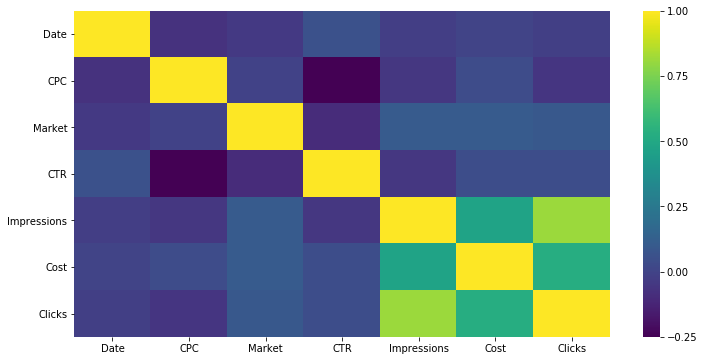

In [14]:
corr = scaled_df.corr()

plt.figure(figsize = (12,6))
sns.heatmap(data = corr, cmap = 'viridis')

In [15]:
#sns.distplot((y_test-predictions), bins = 30)

In [16]:
corr = new_df.corr()

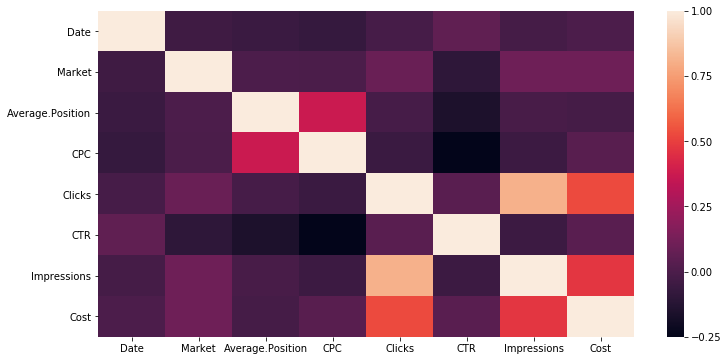

In [17]:
plt.figure(figsize = (12,6))
sns.heatmap(corr)

In [18]:
new_df['Clicks'].corr(new_df['Cost'])

0.530799129556749

## Deep Learning Model:

In [19]:
scaled_df.columns

Index(['Date', 'CPC', 'Market', 'CTR', 'Impressions', 'Cost', 'Clicks'], dtype='object')

In [20]:
model = Sequential()
model.add(Dense(8, input_dim = 6, activation = 'relu'))
model.add(Dense(8, activation = 'relu'))
model.add(Dense(8, activation = "relu"))
model.add(Dense(1, activation = 'linear'))
model.summary()

W1028 16:21:39.173749 139782750127936 deprecation_wrapper.py:119] From /home/umairshah/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:47: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1028 16:21:39.195588 139782750127936 deprecation_wrapper.py:119] From /home/umairshah/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:349: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1028 16:21:39.199387 139782750127936 deprecation_wrapper.py:119] From /home/umairshah/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3147: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8)                 56        
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 209.0
Trainable params: 209
Non-trainable params: 0.0
_________________________________________________________________


In [21]:
model.compile(loss = 'mse', optimizer = 'adam', metrics = ['accuracy'])

W1028 16:21:42.246147 139782750127936 deprecation_wrapper.py:119] From /home/umairshah/anaconda3/lib/python3.7/site-packages/keras/optimizers.py:675: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [24]:
scaled_df.columns

Index(['Date', 'CPC', 'Market', 'CTR', 'Impressions', 'Cost', 'Clicks'], dtype='object')

In [25]:
X = scaled_df.drop('Clicks', axis = 1)
y = scaled_df['Clicks']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 101)

In [26]:
history = model.fit(x = X_train, y = y_train, epochs = 20, batch_size = 128,
                   validation_split = 0.2)

Train on 114012 samples, validate on 28504 samples
Epoch 1/20


KeyError: "None of [Int64Index([ 31762, 113336,  63289,  60186,  95511,  58059,     75,  80975,\n             90782,  24797,\n            ...\n            107446,  36960,  15870,  55728,  89038,  59954,  92905,  34025,\n            106536,  10666],\n           dtype='int64', length=128)] are in the [columns]"

In [42]:
X.head()

,Date,CPC,Market,CTR,Impressions,Cost
0,-0.502160,-0.507390,-1.467025,-0.577179,-0.169218,-0.250730
1,1.960034,-0.250947,0.681652,0.501155,-0.172698,-0.222662
2,-0.551301,-0.052151,-1.467025,1.733537,-0.174240,-0.185185
3,-0.575872,-0.243317,0.681652,-0.166385,0.154404,0.534952
4,-0.473269,-0.316011,0.681652,-0.885275,-0.164517,-0.239196


In [44]:
print(X.shape)
print(y.shape)

(203595, 6)
(203595,)


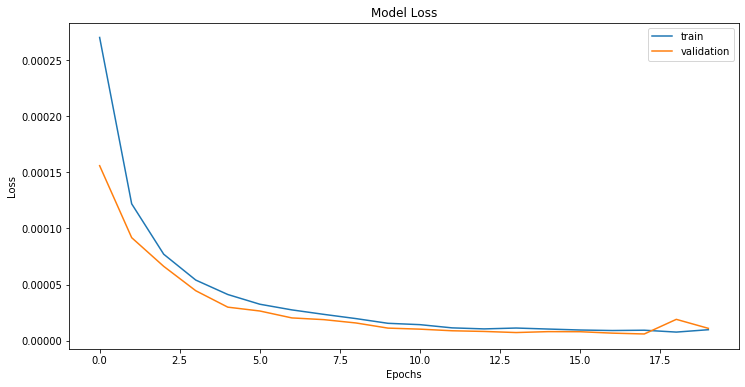

In [30]:
plt.figure(figsize = (12,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'], loc = 'upper_right')
plt.show()

## Word2Vec Model for Word Embeddings:

In [27]:
######## DEALING WITH KEYWORDS COLUMNS ############:

keywords_list = list(new_df['Keyword'])
cleaned_keyword_list = list()
for line in keywords_list:
    rem_token_punc = RegexpTokenizer(r'\w+')
    tokens = rem_token_punc.tokenize(line)
    # print(tokens)
    words = [w.lower() for w in tokens]
    # print(words)
    words = [word for word in words if not word in stopwords]
    # print(words)
    cleaned_keyword_list.append(words)
    
print(cleaned_keyword_list[:10])
print(len(cleaned_keyword_list))

EMB_dim = 32

# train Word2Vec model
model = gensim.models.Word2Vec(sentences = cleaned_keyword_list, size = EMB_dim, workers = 4, min_count = 1)
# vocabulary size
words = list(model.wv.vocab)
print("Here is the Vocabulary Size .. %d" % len(words))

[['agile', 'management', 'software'], ['android', 'app', 'developers'], ['android', 'application', 'developer'], ['android', 'app', 'developer'], ['mobile', 'applications', 'developers'], ['cloud', 'computing', 'dummies'], ['apps', 'development'], ['mobile', 'apps', 'developers'], ['joomla', 'designers'], ['ink', '8560']]
203595
Here is the Vocabulary Size .. 729


In [28]:
model.wv.most_similar("insurance")

[('tracking', 0.7912771105766296),
 ('21', 0.7328250408172607),
 ('assurance', 0.628747820854187),
 ('quote', 0.6262915134429932),
 ('term', 0.5759748220443726),
 ('aetna', 0.5728580951690674),
 ('century', 0.5653750896453857),
 ('plans', 0.563106894493103),
 ('universal', 0.5619962215423584),
 ('private', 0.5603671669960022)]

In [29]:
scaled_df.columns

Index(['Date', 'CPC', 'Market', 'CTR', 'Impressions', 'Cost', 'Clicks'], dtype='object')

In [42]:
inputA = Input(shape=(6,))
inputB = Input(shape=(724,))
 
# the first branch operates on the first input
x = Dense(8, activation="relu")(inputA)
x = Dense(8, activation="relu")(x)
x = Dense(8, activation = "relu")(x)
x = Dense(1, activation = "linear")(x)
x = Model(inputs=inputA, outputs=x)
 
# the second branch opreates on the second input
y = Dense(64, activation="relu")(inputB)
y = Dense(32, activation="relu")(y)
y = Dense(16, activation="relu")(y)
y = Dense(4, activation = "linear")(y)
y = Model(inputs=inputB, outputs=y)
 
# combine the output of the two branches
combined = concatenate([x.output, y.output])
 
# apply a FC layer and then a regression prediction on the
# combined outputs
z = Dense(8, activation="relu")(combined)
z = Dense(8, activation="relu")(z)
z = Dense(8, activation = "relu")(z)
z = Dense(1, activation = "linear")(z)
 
# our model will accept the inputs of the two branches and
# then output a single value
model = Model(inputs=[x.input, y.input], outputs=z)

In [43]:
model.compile(optimizer = 'adam', loss = 'mse', metrics = ['accuracy'])

In [44]:
history = model.fit([X_train, X_text_train], y_train,
                   validation_data = ([X_test, X_text_test], y_test), epochs = 20, batch_size = 64)

Train on 142516 samples, validate on 61079 samples
Epoch 1/20
142516/142516 [==============================] - 12s 86us/step - loss: 2835080.0930 - accuracy: 2.2454e-04 - val_loss: 1321992.9181 - val_accuracy: 8.1861e-05
Epoch 2/20
142516/142516 [==============================] - 12s 82us/step - loss: 855953.9600 - accuracy: 4.9117e-05 - val_loss: 555922.5004 - val_accuracy: 1.6372e-04
Epoch 3/20
142516/142516 [==============================] - 12s 82us/step - loss: 548754.9543 - accuracy: 1.4735e-04 - val_loss: 440662.4326 - val_accuracy: 8.1861e-05
Epoch 4/20
142516/142516 [==============================] - 12s 81us/step - loss: 422542.4697 - accuracy: 9.1218e-05 - val_loss: 382156.0289 - val_accuracy: 3.2744e-05
Epoch 5/20
142516/142516 [==============================] - 12s 81us/step - loss: 293361.5455 - accuracy: 9.1218e-05 - val_loss: 275304.2907 - val_accuracy: 1.6372e-05
Epoch 6/20
142516/142516 [==============================] - 12s 83us/step - loss: 202524.1856 - accuracy: 8

In [45]:
history.history.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

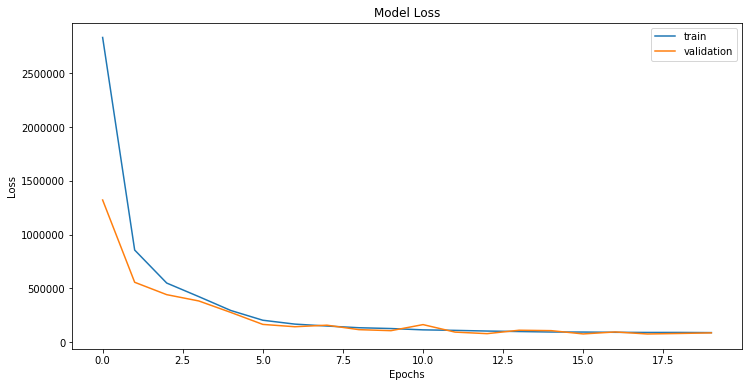

In [46]:
plt.figure(figsize = (12,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'], loc = 'upper_right')
plt.show()

## The TF-IDF Approach

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [31]:
corpus = list(new_df['Keyword'])
vectorizer = TfidfVectorizer()

tf_corpus = vectorizer.fit_transform(corpus)

# print(vectorizer.get_feature_names())
# print(len(vectorizer.get_feature_names()))

X_text = tf_corpus
y = new_df['Clicks']

X_text_train, X_text_test, y_train, y_test = train_test_split(X_text, y, test_size = 0.3, random_state = 101)

print(X_text_train.shape)
print(y_train.shape)

model1 = Sequential()

model1.add(Dense(8, activation = "relu", input_dim = X_text_train.shape[1]))
model1.add(Dense(8, activation = "relu"))
model1.add(Dense(8, activation = "relu"))
model1.add(Dense(1, activation = "linear"))

model1.compile(optimizer = "adam", loss = "mse", metrics = ["accuracy"])

(142516, 724)
(142516,)


In [32]:
history = model1.fit(x = X_text_train, y = y_train, batch_size = 64, epochs = 50,
         verbose = 1, validation_split = 0.2)

TypeError: sparse matrix length is ambiguous; use getnnz() or shape[0]

In [39]:
history.history.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

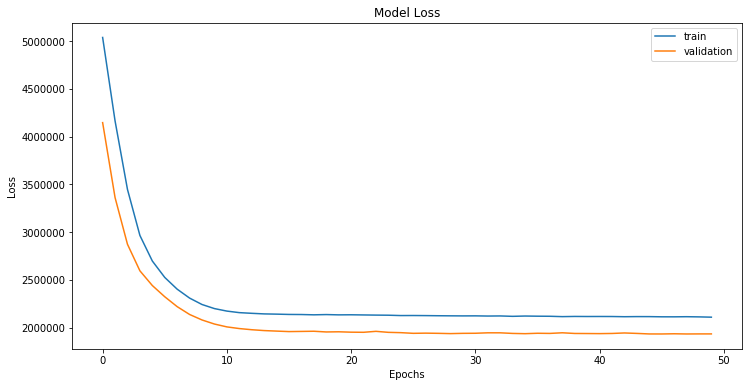

In [40]:
plt.figure(figsize = (12,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'], loc = 'upper_right')
plt.show()

## Question No. 01

__How did you manipulate the data, and why? Illustrate your answer with plots.__

The Data manipulation was not a big deal. The only thing, which has made this problem a bit tricky and challenging is, we had various types of feature inputs. And we needed to manipulate almost all those (Numerical, Categorical and Text inputs) to train our model. For this we needed to create such model that would receive all these inputs at a time and for that obviously we needed to transforms all those non-numerical features, to something that our can get trained on. And this is what we're gonna discuss in detail in next questions.

As far as the features selection is concerned, __Market, Keyword, and CPC__ are the ones which we needed to predict our model results on. So, we have to keep them in our dataset. __Impressions and Cost__ are that ones, that impacted our target variable the most, and needed to be kept in dataset. __CTR__ generally made sense to be kept in dataset, and also if we would drop more features, our model might end up __underfitting__. __Heatmap__ below shows the clear picture.

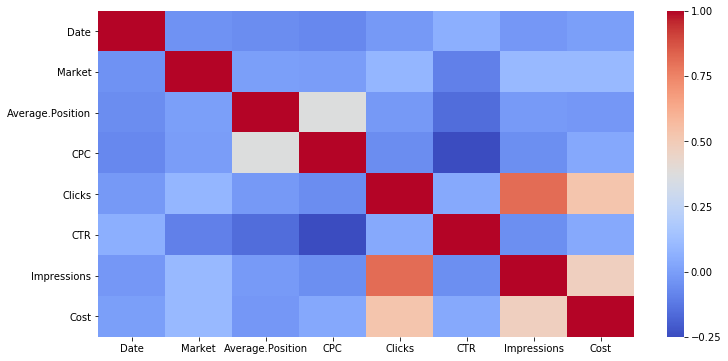

In [45]:
plt.figure(figsize = (12,6))
sns.heatmap(corr, cmap = 'coolwarm')